Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from scipy.stats import median_abs_deviation as madma
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Load the training data into numpy array.

In [2]:
with pd.HDFStore('MiningProcess_Flotation_Plant_Database_train_split.h5') as store:
    df_train = store.get('train_data')
    df_test = store.get('test_data')
    df_validation = store.get('validation_data')

X = df_train.iloc[:,2:-2].to_numpy()

KeyError: 'No object named train_data in the file'

Initialize different pretreatment models

In [3]:
# Initializing the models as a list of dictionaries
models = [{'X': X},  # No pretreatment
          {'X': X - np.mean(X, axis=0)},  # Mean centered
          {'X': StandardScaler().fit_transform(X)},  # Z-score (STD)
          {'X': StandardScaler().fit_transform(X - np.mean(X, axis=0))},  # Z-score on centered
          {'X': RobustScaler().fit_transform(X)},  # Robust z-score
          {'X': normalize(X - np.mean(X, axis=0), norm='l2')},  # Center and p-norm
          {'X': StandardScaler(with_mean=True, with_std=False).fit_transform(X) / madma(X)}]  # Centered, MAD-scaled


Run PCA for each model

In [4]:
# Running PCA for each pretreatment model
for model in models:
    pca_model = PCA()
    model['T'] = pca_model.fit_transform(model['X'])  # Scores
    model['P'] = pca_model.components_  # Loadings


Visualize the loadings of the 1st principal component for each model

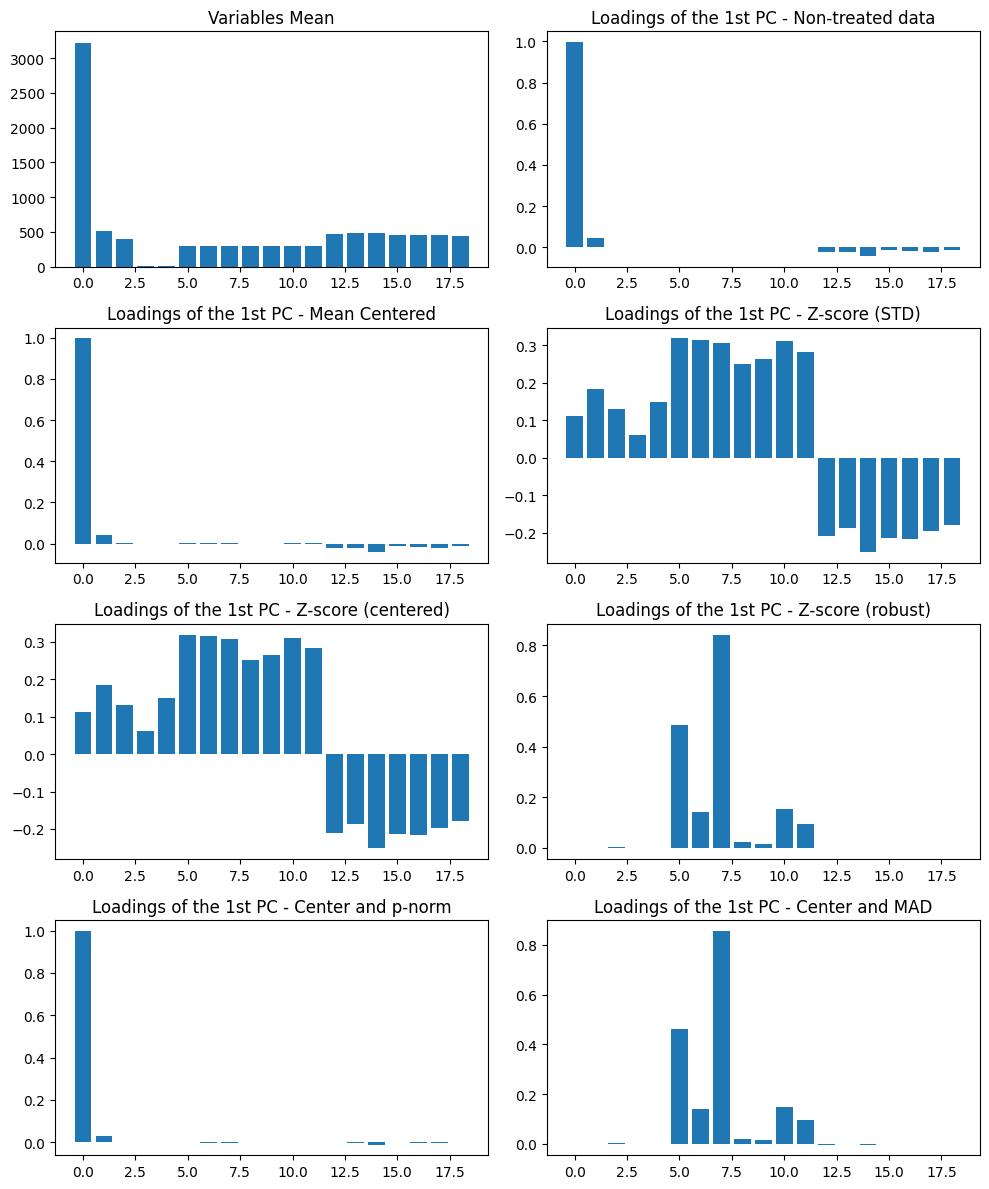

In [5]:

# Labeling each pretreatment method
treatments = ["Non-treated data", "Mean Centered", "Z-score (STD)", "Z-score (centered)",
              "Z-score (robust)", "Center and p-norm", "Center and MAD"]
for i, treatment in enumerate(treatments):
    models[i]['treatmentName'] = treatment

# Calculate mean of original variables
Mean = np.mean(X, axis=0)

# Plotting the mean of variables
fig, axs = plt.subplots(4, 2, figsize=(10, 12))
axs[0, 0].bar(range(len(Mean)), Mean)
axs[0, 0].set_title("Variables Mean")

# Plotting the loadings of the 1st principal component for each pretreatment
for i, model in enumerate(models):
    axs[(i+1)//2, (i+1)%2].bar(range(len(model['P'][0])), model['P'][0])
    axs[(i+1)//2, (i+1)%2].set_title(f"Loadings of the 1st PC - {model['treatmentName']}")
plt.tight_layout()
plt.show()


Visualize the scores of PC1 vs PC2

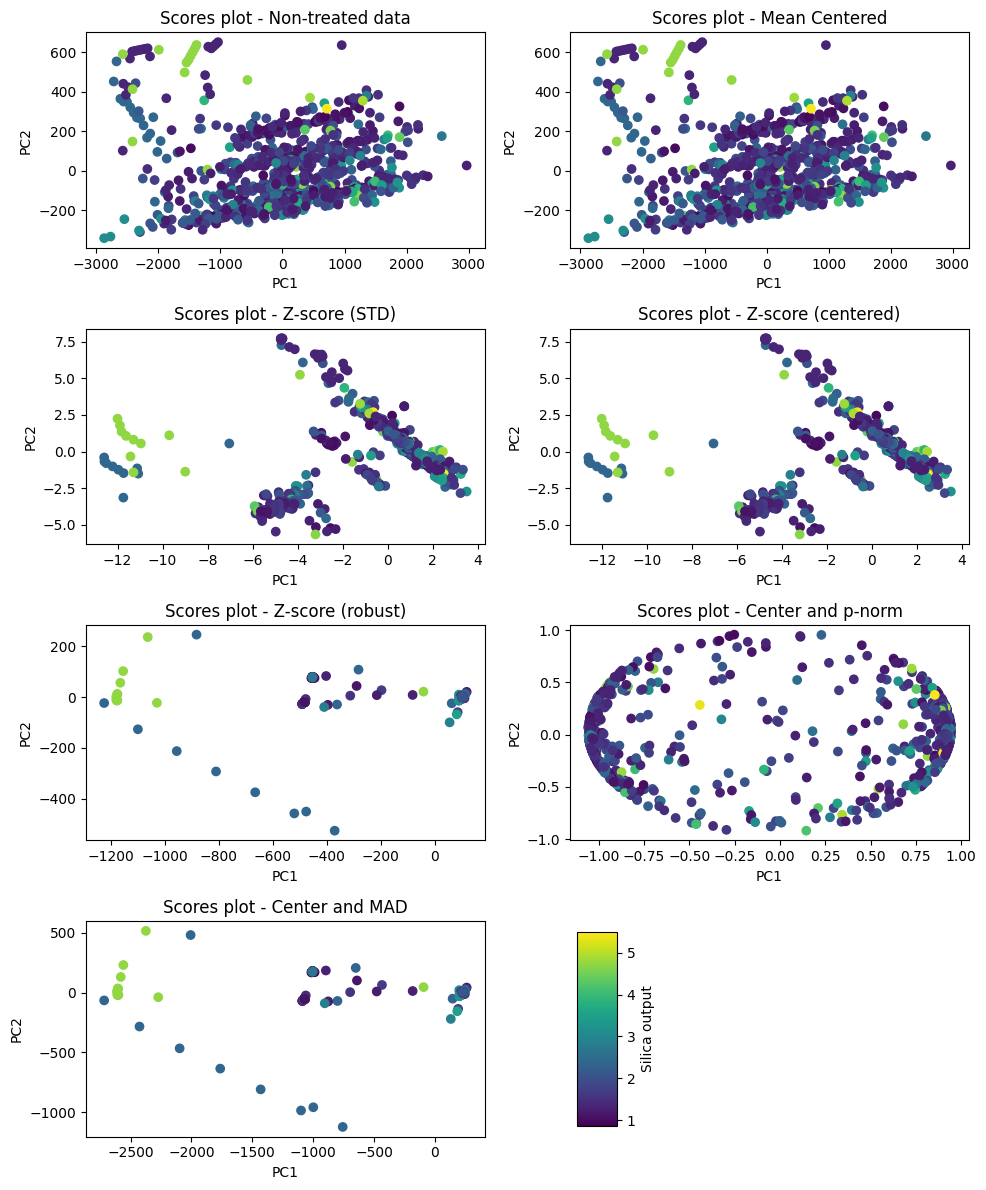

In [6]:

# Scatter plots of PC1 vs PC2 (Scores plots)
fig, axs = plt.subplots(4, 2, figsize=(10, 12))
for i, model in enumerate(models):
    im = axs[i//2, i%2].scatter(model['T'][:, 0], model['T'][:, 1],c=df_train['% Silica Concentrate'])
    axs[i//2, i%2].set_xlabel("PC1")
    axs[i//2, i%2].set_ylabel("PC2")
    axs[i//2, i%2].set_title(f"Scores plot - {model['treatmentName']}")
plt.tight_layout()
inset_ax = inset_axes(axs[3,1], width="10%", height="90%", loc='center left')
axs[3,1].set_axis_off()
plt.colorbar(im, inset_ax, label='Silica output')
plt.show()
